# NivLink Demo: Free-Viewing

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('white')
sns.set_context('notebook', font_scale=1.5)
%matplotlib inline

## Section 1: Simulate Data

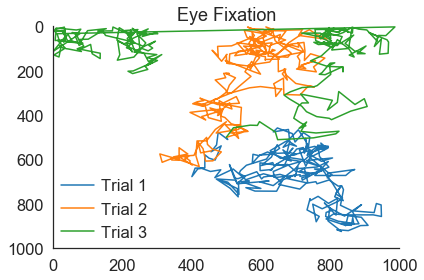

In [2]:
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Define metadata.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

xdim = ydim = 1000

n_trials = 3
n_steps = 250

mu = np.array([xdim/2, ydim/2])
drift = 30

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Simulate data.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
np.random.seed(47404)

## Preallocate space.
eyepos = np.zeros((n_trials, n_steps, 2))
eyepos[:,0,:] = mu

## Random walk.
for i in np.arange(1,n_steps):
    
    ## Drift.
    eyepos[:,i,:] = eyepos[:,i-1,:] + np.random.normal(0,drift,(n_trials,2))
    
    ## Boundary correct.
    eyepos = np.where(eyepos > xdim, xdim - eyepos, eyepos)
    eyepos = np.where(eyepos < 0, 0 - eyepos, eyepos)
    
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Plot eyetracking.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Initalize canvas.
fig, ax = plt.subplots(1,1,figsize=(6,4))

## Plotting.
for i, arr in enumerate(eyepos): ax.plot(*arr.T, label='Trial %s' %(i+1))
ax.set(xlim=(0,xdim),ylim=(0,ydim),title='Eye Fixation')
ax.legend(loc=3, frameon=False, borderpad=0, handletextpad=0.4)
ax.invert_yaxis()

sns.despine()
plt.tight_layout()

## Section 2: Convert Data for NivLink

In [3]:
from numpy import unicode_

## Prepare data.
data = eyepos.reshape(-1, 2)
data = np.column_stack([data, np.zeros(data.shape[0])])
ch_names = ['gx', 'gy', 'pupil']

## Define metadata.
info = dict(sfreq = 125, eye = 'RIGHT', pupil='AREA')

## Define blinks.
blinks = np.array([], dtype=int).reshape(0,2)

## Define saccades.
saccades = np.array([], dtype=int).reshape(0,2)

## Define messages.
messages = np.array([(0, 'Trial 1'), (250, 'Trial 2'), (500, 'Trial 3')],
                    dtype=[('sample',int),('message',unicode_, 80)])

## Save to file.
np.savez_compressed('demo.npz', info=info, data=data, blinks=blinks, saccades=saccades,
                    messages=messages, ch_names=ch_names)

## Section 3: Load and Prepare data

In [4]:
from nivlink import Raw, Epochs

## Load raw data.
raw = Raw('demo.npz')

## Find events.
events = raw.find_events('Trial')

## Epoch data.
epochs = Epochs(raw, events, tmin=0, tmax=1, picks='gaze')

## Section 4: Define Screen Object

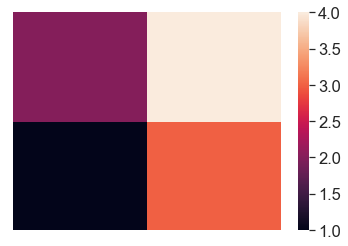

In [5]:
from nivlink import Screen

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Define areas of interest.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Initialize object.
screen = Screen(xdim, ydim, 1)

## Add areas of interest.
screen.add_rectangle_aoi(0, xdim/2, 0, ydim/2)
screen.add_rectangle_aoi(xdim/2, xdim, 0, ydim/2)
screen.add_rectangle_aoi(0, xdim/2, ydim/2, ydim)
screen.add_rectangle_aoi(xdim/2, xdim, ydim/2, ydim)

## Plot areas of interest.
ax = sns.heatmap(screen.indices.squeeze(), xticklabels=[], yticklabels=[])
ax.invert_yaxis()

## Section 5: Alignment and Results

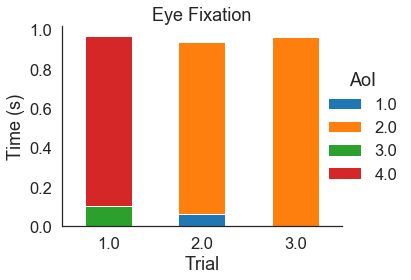

In [6]:
from nivlink import align_to_aoi, compute_fixations

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Align to areas of interest.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

aligned = align_to_aoi(epochs, screen, np.array([1,1,1]))

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Compute fixations.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

fixations = compute_fixations(aligned, epochs.times)

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Plot fixations.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## GroupBy / pivot table.
data = fixations.groupby(['Trial','AoI']).Duration.sum().reset_index()
data = data.pivot('Trial','AoI','Duration')

## Plotting.
ax = data.plot.bar(stacked=True,rot=0)
ax.set(ylabel='Time (s)', title='Eye Fixation')
legend = ax.legend(loc=7,bbox_to_anchor=(1.25,0.5),frameon=False,title='AoI')
legend.get_title().set_fontsize('18')

sns.despine()
plt.tight_layout()